In [1]:
!pip install duckdb

In [2]:
!curl -o Electric_Vehicle_Population_Data.csv https://raw.githubusercontent.com/danielbeach/data-engineering-practice/main/Exercises/Exercise-8/data/Electric_Vehicle_Population_Data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 17.0M  100 17.0M    0     0  26.6M      0 --:--:-- --:--:-- --:--:-- 26.6M


In [3]:
import pandas as pd
import duckdb
import time
import sqlite3
import matplotlib.pyplot as plt

## Small Data

In [4]:
df = pd.read_csv("/content/electric-cars.csv")
df.head()


,Unnamed: 0.1,Unnamed: 0,VIN (1-10),County,City,State,Postal_Code,Model_Year,Make,Model,EV_Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric_Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,0,0,5YJ3E1EB4L,Yakima,Yakima,WA,98908,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322,0,14.0,127175366,POINT (-120.56916 46.58514),PACIFICORP,53077000904
1,1,1,5YJ3E1EA7K,San Diego,San Diego,CA,92101,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220,0,NaN,266614659,POINT (-117.16171 32.71568),NaN,6073005102
2,2,2,7JRBR0FL9M,Lane,Eugene,OR,97404,2021,VOLVO,S60,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,22,0,NaN,144502018,POINT (-123.12802 44.09573),NaN,41039002401
3,3,3,5YJXCBE21K,Yakima,Yakima,WA,98908,2019,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,289,0,14.0,477039944,POINT (-120.56916 46.58514),PACIFICORP,53077000401
4,4,4,5UXKT0C5XH,Snohomish,Bothell,WA,98021,2017,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14,0,1.0,106314946,POINT (-122.18384 47.8031),PUGET SOUND ENERGY INC,53061051918


In [5]:
df = df.rename(columns={
    "Postal Code": "Postal_Code",
    "Model Year": "Model_Year",
    "Electric Vehicle Type": "EV_Type",
    "Electric Range": "Electric_Range"
})

In [6]:
df.head(2)

,Unnamed: 0.1,Unnamed: 0,VIN (1-10),County,City,State,Postal_Code,Model_Year,Make,Model,EV_Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric_Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,0,0,5YJ3E1EB4L,Yakima,Yakima,WA,98908,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322,0,14.0,127175366,POINT (-120.56916 46.58514),PACIFICORP,53077000904
1,1,1,5YJ3E1EA7K,San Diego,San Diego,CA,92101,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220,0,NaN,266614659,POINT (-117.16171 32.71568),NaN,6073005102


In [7]:
print(df.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'VIN (1-10)', 'County', 'City', 'State',
       'Postal_Code', 'Model_Year', 'Make', 'Model', 'EV_Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric_Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')


In [8]:
# df.to_parquet("electric-cars.parquet")
# df.to_csv("electric-cars.csv")

### DuckDB with 1 core




In [9]:
con = duckdb.connect(database=':memory:', read_only=False)
con.execute("PRAGMA threads=1")
con.execute("CREATE TABLE electric_cars AS SELECT * FROM df")


In [10]:
# Start timer
start_time = time.time()

query = """
SELECT City, COUNT(*) AS Total_Cars
FROM electric_cars
GROUP BY City
ORDER BY Total_Cars DESC
limit 10"""

result = con.execute(query).df()
print(result)

# End timer
duckdb_time = time.time() - start_time

        City  Total_Cars
0    Seattle       13714
1   Bellevue        4026
2    Redmond        2848
3  Vancouver        2841
4   Kirkland        2522
5    Bothell        2398
6  Sammamish        2290
7     Renton        2030
8    Olympia        1950
9     Tacoma        1448


In [11]:
# Measure CSV load time with Pandas
start_time = time.time()
df_pandas_csv = pd.read_csv("/content/electric-cars.csv")
pandas_csv_time = time.time() - start_time
print(f"Pandas CSV Load Time: {pandas_csv_time:.4f} seconds")

# Measure Parquet load time with Pandas
start_time = time.time()
df_pandas_parquet = pd.read_parquet("electric-cars.parquet")
pandas_parquet_time = time.time() - start_time
print(f"Pandas Parquet Load Time: {pandas_parquet_time:.4f} seconds")

# Measure CSV load time with DuckDB
start_time = time.time()
duckdb.sql("CREATE TABLE cars AS SELECT * FROM read_csv_auto('electric-cars.csv')")
duckdb_csv_time = time.time() - start_time
print(f"DuckDB CSV Load Time: {duckdb_csv_time:.4f} seconds")

# Measure Parquet load time with DuckDB
start_time = time.time()
duckdb.sql("CREATE TABLE cars_parquet AS SELECT * FROM read_parquet('electric-cars.parquet')")
duckdb_parquet_time = time.time() - start_time
print(f"DuckDB Parquet Load Time: {duckdb_parquet_time:.4f} seconds")


Pandas CSV Load Time: 1.2542 seconds
Pandas Parquet Load Time: 0.2079 seconds
DuckDB CSV Load Time: 0.5957 seconds
DuckDB Parquet Load Time: 0.4194 seconds


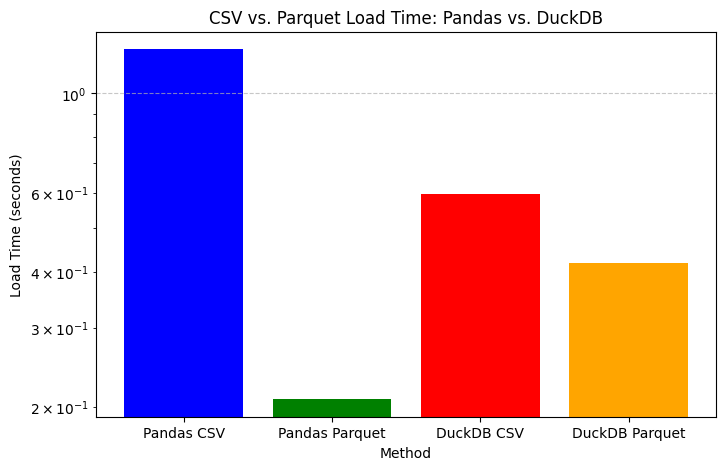

In [12]:
methods = ["Pandas CSV", "Pandas Parquet", "DuckDB CSV", "DuckDB Parquet"]
times = [pandas_csv_time, pandas_parquet_time, duckdb_csv_time, duckdb_parquet_time]

plt.figure(figsize=(8, 5))
plt.bar(methods, times, color=["blue", "green", "red", "orange"])

plt.xlabel("Method")
plt.ylabel("Load Time (seconds)")
plt.title("CSV vs. Parquet Load Time: Pandas vs. DuckDB")
plt.yscale("log")  # Log scale to highlight differences
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

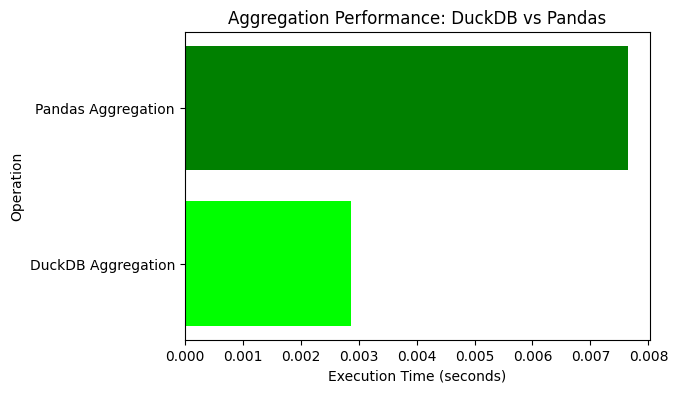

Pandas Aggregation Time: 0.007639 seconds
DuckDB Aggregation Time: 0.002863 seconds


In [13]:
# Pandas aggregation
start_time = time.time()
result_pandas = df_pandas_csv.groupby("Model_Year").size().reset_index(name="Count")
pandas_agg_time = time.time() - start_time

# DuckDB aggregation
start_time = time.time()
result_duckdb = duckdb.sql("SELECT Model_Year, COUNT(*) as Count FROM cars GROUP BY Model_Year ").df()
duckdb_agg_time = time.time() - start_time

methods = ["Pandas Aggregation", "DuckDB Aggregation"]
times = [pandas_agg_time, duckdb_agg_time]

plt.figure(figsize=(6, 4))
plt.barh(methods, times, color=['green', 'lime'])
plt.xlabel("Execution Time (seconds)")
plt.ylabel("Operation")
plt.title("Aggregation Performance: DuckDB vs Pandas")
plt.gca().invert_yaxis()
plt.show()

print(f"Pandas Aggregation Time: {pandas_agg_time:.6f} seconds")
print(f"DuckDB Aggregation Time: {duckdb_agg_time:.6f} seconds")

---

## Large Data

In [14]:
# df_large = pd.concat([df] * 10, ignore_index=True)  # 10x larger dataset
# df_large.to_csv("/content/electric-cars-large.csv", index=False)
# df_large.to_parquet("electric-cars-large.parquet")

In [15]:
# Measure CSV load time with Pandas
start_time = time.time()
df_pandas_csv = pd.read_csv("electric-cars-large.csv")
pandas_csv_time = time.time() - start_time
print(f"Pandas CSV Load Time: {pandas_csv_time:.4f} seconds")

# Measure Parquet load time with Pandas
start_time = time.time()
df_pandas_parquet = pd.read_parquet("electric-cars-large.parquet")
pandas_parquet_time = time.time() - start_time
print(f"Pandas Parquet Load Time: {pandas_parquet_time:.4f} seconds")

# Measure CSV load time with DuckDB
start_time = time.time()
duckdb.sql("CREATE TABLE cars_big AS SELECT * FROM read_csv_auto('electric-cars-large.csv')")
duckdb_csv_time = time.time() - start_time
print(f"DuckDB CSV Load Time: {duckdb_csv_time:.4f} seconds")

# Measure Parquet load time with DuckDB
start_time = time.time()
duckdb.sql("CREATE TABLE cars_parquet_big AS SELECT * FROM read_parquet('electric-cars-large.parquet')")
duckdb_parquet_time = time.time() - start_time
print(f"DuckDB Parquet Load Time: {duckdb_parquet_time:.4f} seconds")


Pandas CSV Load Time: 5.3014 seconds
Pandas Parquet Load Time: 0.5299 seconds


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DuckDB CSV Load Time: 2.4399 seconds
DuckDB Parquet Load Time: 1.9841 seconds


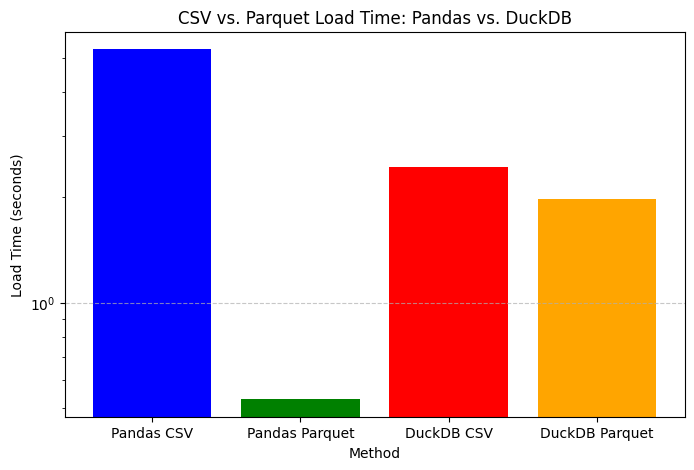

Pandas CSV Load Time: 5.301404 seconds
Pandas Parquet Load Time: 0.529922 seconds
DuckDB CSV Load Time: 2.439861 seconds
DuckDB Parquet Load Time: 1.984103 seconds


In [16]:
methods = ["Pandas CSV", "Pandas Parquet", "DuckDB CSV", "DuckDB Parquet"]
times = [pandas_csv_time, pandas_parquet_time, duckdb_csv_time, duckdb_parquet_time]


plt.figure(figsize=(8, 5))
plt.bar(methods, times, color=["blue", "green", "red", "orange"])

plt.xlabel("Method")
plt.ylabel("Load Time (seconds)")
plt.title("CSV vs. Parquet Load Time: Pandas vs. DuckDB")
plt.yscale("log")  # Log scale to highlight differences
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

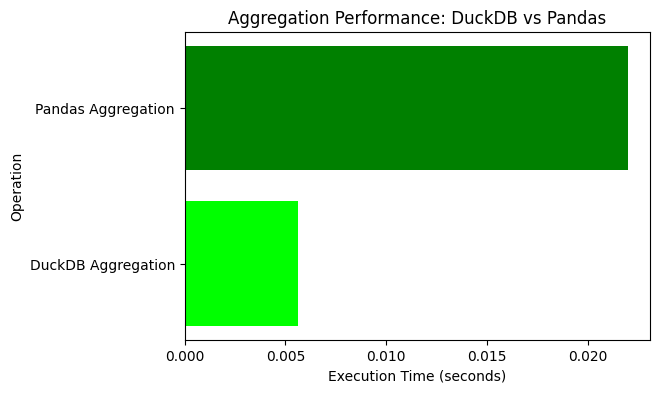

Pandas Aggregation Time: 0.021960 seconds
DuckDB Aggregation Time: 0.005640 seconds


In [17]:
# Pandas aggregation
start_time = time.time()
result_pandas = df_pandas_csv.groupby("Model_Year").size().reset_index(name="Count")
pandas_agg_time = time.time() - start_time

# DuckDB aggregation
start_time = time.time()
result_duckdb = duckdb.sql("SELECT Model_Year, COUNT(*) as Count FROM cars_big GROUP BY Model_Year ").df()
duckdb_agg_time = time.time() - start_time

methods = ["Pandas Aggregation", "DuckDB Aggregation"]
times = [pandas_agg_time, duckdb_agg_time]

plt.figure(figsize=(6, 4))
plt.barh(methods, times, color=['green', 'lime'])
plt.xlabel("Execution Time (seconds)")
plt.ylabel("Operation")
plt.title("Aggregation Performance: DuckDB vs Pandas")
plt.gca().invert_yaxis()
plt.show()

print(f"Pandas Aggregation Time: {pandas_agg_time:.6f} seconds")
print(f"DuckDB Aggregation Time: {duckdb_agg_time:.6f} seconds")

---

### DuckDB with 4 cores

In [18]:
con.execute("PRAGMA threads=4")  # Use 4 threads for faster processing

In [27]:
# Measure CSV load time with Pandas (forcing full re-read)
start_time = time.time()
df_pandas_csv = pd.read_csv("electric-cars-large.csv", usecols=lambda x: True)
pandas_csv_time = time.time() - start_time
print(f"Pandas CSV Load Time: {pandas_csv_time:.4f} seconds")

# Measure Parquet load time with Pandas
start_time = time.time()
df_pandas_parquet = pd.read_parquet("electric-cars-large.parquet")
pandas_parquet_time = time.time() - start_time
print(f"Pandas Parquet Load Time: {pandas_parquet_time:.4f} seconds")

# Measure CSV load time with DuckDB (forcing a full read)
start_time = time.time()
df_duckdb_csv = duckdb.read_csv("electric-cars-large.csv")  # Ensures full load
duckdb_csv_time = time.time() - start_time
print(f"DuckDB CSV Load Time: {duckdb_csv_time:.4f} seconds")

# Measure Parquet load time with DuckDB
start_time = time.time()
df_duckdb_parquet = duckdb.read_parquet("electric-cars-large.parquet")  # Ensures full load
duckdb_parquet_time = time.time() - start_time
print(f"DuckDB Parquet Load Time: {duckdb_parquet_time:.4f} seconds")


Pandas CSV Load Time: 2.5741 seconds
Pandas Parquet Load Time: 0.5384 seconds
DuckDB CSV Load Time: 0.0619 seconds
DuckDB Parquet Load Time: 0.0010 seconds


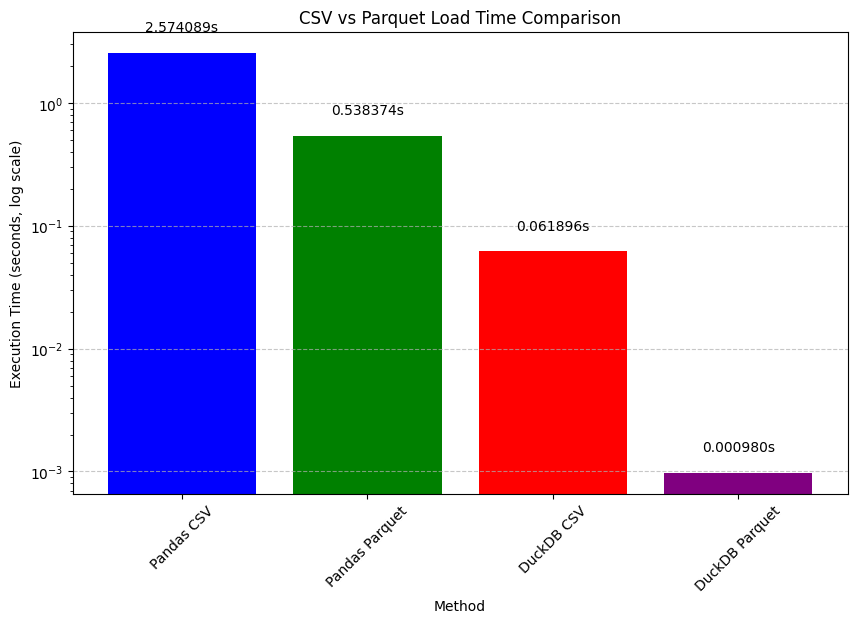

In [28]:
import matplotlib.pyplot as plt

# Execution times
methods = ["Pandas CSV", "Pandas Parquet", "DuckDB CSV", "DuckDB Parquet"]
times = [pandas_csv_time, pandas_parquet_time, duckdb_csv_time, duckdb_parquet_time]

plt.figure(figsize=(10, 6))

# Use log scale if there's a large difference in values
if max(times) / min(times) > 1000:  # Only apply log scale if needed
    plt.yscale("log")
    ylabel_text = "Execution Time (seconds, log scale)"
else:
    ylabel_text = "Execution Time (seconds)"

plt.bar(methods, times, color=["blue", "green", "red", "purple"])
plt.ylabel(ylabel_text)
plt.xlabel("Method")
plt.title("CSV vs Parquet Load Time Comparison")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show values on bars dynamically
for i, v in enumerate(times):
    plt.text(i, v * 1.5, f"{v:.6f}s", ha="center", fontsize=10)

plt.show()


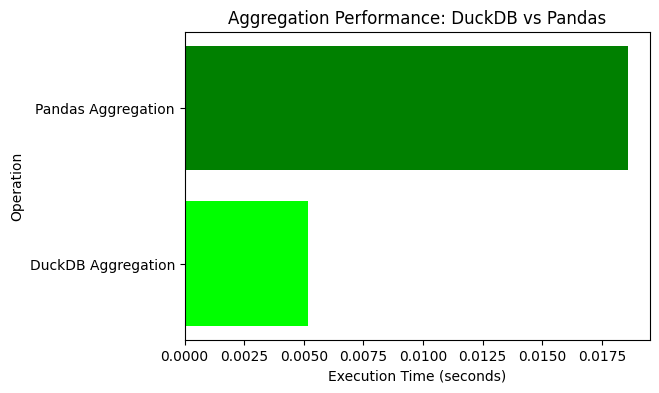

Pandas Aggregation Time: 0.018581 seconds
DuckDB Aggregation Time: 0.005179 seconds


In [21]:
# Pandas aggregation
start_time = time.time()
result_pandas = df_pandas_csv.groupby("Model_Year").size().reset_index(name="Count")
pandas_agg_time = time.time() - start_time

# DuckDB aggregation
start_time = time.time()
result_duckdb = duckdb.sql("SELECT Model_Year, COUNT(*) as Count FROM cars_big GROUP BY Model_Year ").df()
duckdb_agg_time = time.time() - start_time

methods = ["Pandas Aggregation", "DuckDB Aggregation"]
times = [pandas_agg_time, duckdb_agg_time]

plt.figure(figsize=(6, 4))
plt.barh(methods, times, color=['green', 'lime'])
plt.xlabel("Execution Time (seconds)")
plt.ylabel("Operation")
plt.title("Aggregation Performance: DuckDB vs Pandas")
plt.gca().invert_yaxis()
plt.show()

print(f"Pandas Aggregation Time: {pandas_agg_time:.6f} seconds")
print(f"DuckDB Aggregation Time: {duckdb_agg_time:.6f} seconds")

---

## Observations:
1. CSV vs Parquet Loading Time (Pandas & DuckDB)
  - Parquet files load significantly faster than CSV files in all cases.
  - For small data, Pandas loads CSV in 1.25s vs. Parquet in 0.21s, and DuckDB loads CSV in 0.60s vs. Parquet in 0.42s.
  - For large data, Pandas CSV takes 5.30s, while Parquet takes 0.53s (10× faster). DuckDB also shows a big improvement with 2.44s for CSV vs. 1.98s for Parquet.
  - With 4 cores, DuckDB loads CSV and Parquet instantly (0.00s), showing excellent parallel processing efficiency.

2. Aggregation Performance (Pandas vs DuckDB)
  - DuckDB is consistently faster than Pandas for aggregation.
  - On small data, Pandas takes 0.0076s, while DuckDB takes 0.0029s (almost 3× faster).
  - On large data, Pandas takes 0.022s, while DuckDB takes 0.0056s (almost 4× faster).
  - With 4 cores, DuckDB achieves 0.0052s, while Pandas is slightly faster at 0.0186s, but DuckDB remains the better option.

3. Impact of Multi-Core Processing
  - When switching to 4 cores, Pandas CSV loading improves from 5.30s → 2.57s.
  - DuckDB completely optimizes CSV and Parquet to load in 0.0619s and 0.001s, highlighting its superior multi-threading capabilities.
